# Re-writing DLT to follow R. Hyndman's 

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from orbit.dlt_rh import DLTRH
from orbit.eswr import ESWR
from orbit.dlt import DLT
import numpy as np
from orbit.models import get_compiled_stan_model
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components
from orbit.backtest.backtest import TimeSeriesSplitter, Backtest
from orbit.backtest.functions import run_multi_series_backtest

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
DATA_FILE = "./data/iclaims_example.csv"

In [33]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [34]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [35]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [36]:
df=raw_df.copy()

In [37]:
weekly_mat = np.tile(np.eye(52), 9)[:,:df.shape[0]].transpose(1,0)
weekly_mat.shape

(443, 52)

In [38]:
weekly_labels = ["wk"  + str(x) for x in range(1,53)]
# regressor_col = weekly_labels
regressor_col = ['trend.unemploy',	'trend.filling', 'trend.job']

In [39]:
weekly_df = pd.DataFrame(weekly_mat, columns = weekly_labels)

In [40]:
df = pd.concat([df, weekly_df], axis=1)

In [41]:
df.shape

(443, 57)

In [42]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [43]:
response_col = 'claims'

In [44]:
train_df.tail(5)

,week,claims,trend.unemploy,trend.filling,trend.job,wk1,wk2,wk3,wk4,wk5,wk6,wk7,wk8,wk9,wk10,wk11,wk12,wk13,wk14,wk15,wk16,wk17,wk18,wk19,wk20,wk21,wk22,wk23,wk24,wk25,wk26,wk27,wk28,wk29,wk30,wk31,wk32,wk33,wk34,wk35,wk36,wk37,wk38,wk39,wk40,wk41,wk42,wk43,wk44,wk45,wk46,wk47,wk48,wk49,wk50,wk51,wk52
386,2017-05-28,232138,1.125745,1.042308,0.990023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387,2017-06-04,212696,1.125745,1.023357,1.037167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,2017-06-11,234652,1.125745,1.042308,1.001809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,2017-06-18,228883,1.145154,0.985455,1.025381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,2017-06-25,239635,1.183973,1.061259,1.013595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
mod = ESWR(
    is_multiplicative=True, seed=2020,
    num_warmup=4000,
    response_col='claims', date_col='week', 
#     infer_method='map', predict_method='map',
    infer_method='mcmc', predict_method='mean',
    regressor_col=regressor_col,
)

In [46]:
mod.fit(train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [17]:
# fit = mod.aggregated_posteriors['map']
fit = mod.aggregated_posteriors['mean']

In [22]:
x = mod.get_regression_coefs()
x.shape

(1, 392, 3)

In [26]:
b.shape

(1, 392, 3)

In [81]:
fit.keys()

dict_keys(['l', 'l_sm', 'gb', 'gt_sum', 'obs_sigma', 'nu', 'yhat', 'b_sm', 'b', 'reg'])

In [23]:
yhat_in = np.squeeze(fit['yhat'],0)

In [24]:
b = fit['b']
l = fit['l']
gb = fit['gb']
r_in = fit['reg']
b_sm = fit['b_sm']
gt_sum = fit['gt_sum']
l_sm = fit['l_sm']

In [84]:
mod.posterior_samples['reg'].shape

(100, 391)

In [85]:
print(l.shape, b.shape)

(1, 392) (1, 392, 52)


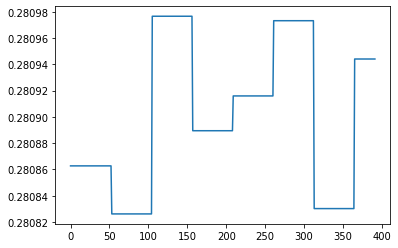

In [86]:
plt.plot(b[0,:,0]) # check varying coefficient of first variable

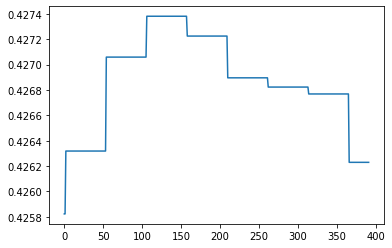

In [87]:
plt.plot(b[0,:,1]) # check varying coefficient of first variable

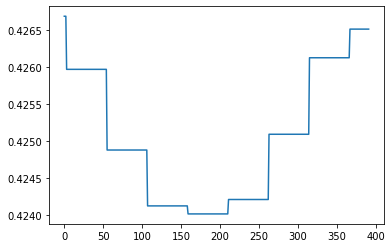

In [88]:
plt.plot(b[0,:,2]) # check varying coefficient of first variable

In [89]:
# b0 = b[:,:1,:]
# b =  np.concatenate([b0, b], axis=1)
b.shape

(1, 392, 52)

In [90]:
# l0 = l[:,:1]
# l =  np.concatenate([l0, l], axis=1)
l.shape

(1, 392)

In [91]:
yhat2 = gt_sum + l[:,:-1] + r_in

In [92]:
yhat2.shape

(1, 391)

In [93]:
yhat2[:,:10]

array([[13.38659513, 13.52967326, 13.54016999, 13.28246283, 13.14291456,
        13.14739118, 13.099685  , 13.01792839, 12.98253167, 13.04299318]])

In [94]:
yhat_in[:10]

array([13.38659513, 13.52967326, 13.54016999, 13.28246283, 13.14291456,
       13.14739118, 13.099685  , 13.01792839, 12.98253167, 13.04299318])

In [95]:
yhat_in

array([13.38659513, 13.52967326, 13.54016999, 13.28246283, 13.14291456,
       13.14739118, 13.099685  , 13.01792839, 12.98253167, 13.04299318,
       12.99020397, 12.93334473, 12.92610317, 12.93536916, 13.03843098,
       13.06486462, 13.00070083, 12.97467315, 12.93265324, 12.92698589,
       12.92100557, 12.94278365, 12.90426457, 13.00039562, 12.99939067,
       13.00197112, 13.03315514, 13.13452239, 13.19587897, 12.96317397,
       12.852411  , 12.85855094, 12.89064217, 12.85720244, 12.84799962,
       12.84956725, 12.80013356, 12.82213166, 12.80441265, 12.79047977,
       12.93580841, 12.97695223, 12.93163728, 12.95175437, 12.99721738,
       13.07232795, 13.02182182, 13.07641852, 13.02081065, 13.2860735 ,
       13.12583135, 13.19251546, 13.27508957, 13.4179502 , 13.43288638,
       13.16615629, 13.03643929, 13.03568604, 12.98319024, 12.90030693,
       12.85716645, 12.89681813, 12.8464821 , 12.7869682 , 12.7790816 ,
       12.78892799, 12.88920723, 12.91621428, 12.85409793, 12.83

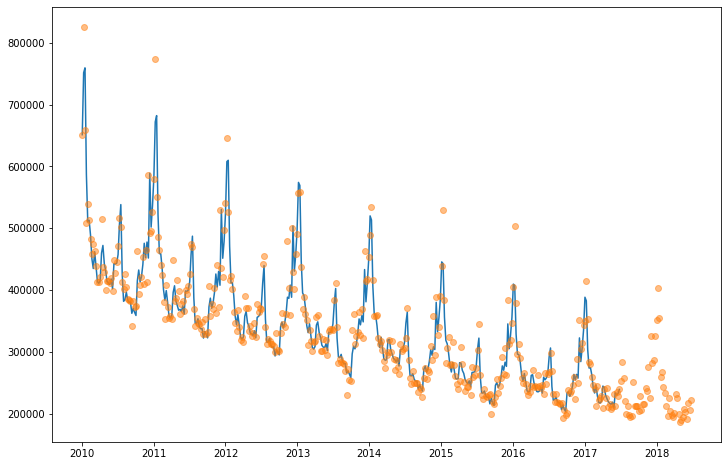

In [96]:
# just a quick check against in-sample yhat
fig, ax = plt.subplots(1,1, figsize=(12,8))
y = df[response_col]
plt.plot(train_df['week'], np.exp(yhat_in))
plt.plot(df['week'], df[response_col], 'o', alpha=0.5)

In [97]:
b_ext = np.transpose(np.tile(np.expand_dims(b[:,-1,:],-1), 51),(0,2,1))
l_ext = np.expand_dims(np.tile(l[:, -1], 51), 0)

In [98]:
l = np.concatenate([l, l_ext], axis=1)
b =  np.concatenate([b, b_ext], axis=1)

In [99]:
gt = gb * np.arange(0, l.shape[1])
gt = gt.reshape(1, -1)

In [100]:
print(l.shape, b.shape, gt.shape)

(1, 443) (1, 443, 52) (1, 443)


In [101]:
x = np.expand_dims(df[regressor_col].values,0)
x.shape

(1, 443, 52)

In [28]:
b.shape

(1, 392, 3)

In [27]:
df[regressor_col].values.shape

(443, 3)

In [102]:
r = x * b
r = np.sum(r, axis=-1)
r.shape

(1, 443)

In [103]:
r[:,:10]

array([[ 0.28086272,  0.42582333,  0.42668715,  0.18792896,  0.0677683 ,
         0.06744861,  0.0215854 , -0.05678514, -0.09243982, -0.04083668]])

In [104]:
r_in[:,:10]

array([[ 0.28086272,  0.42582333,  0.42668715,  0.18792896,  0.0677683 ,
         0.06744861,  0.0215854 , -0.05678514, -0.09243982, -0.04083668]])

In [105]:
# this is special since l explains the initial regression
# init_reg = r[:,0]

In [106]:
# l = l - init_reg

In [107]:
print(l.shape, r.shape, gt.shape)

(1, 443) (1, 443) (1, 443)


In [108]:
yhat= gt + l + r
yhat =np.squeeze(yhat)

In [109]:
yhat.shape

(443,)

In [110]:
yhat[:10]

array([13.38659513, 13.52967326, 13.54016999, 13.28246283, 13.14291456,
       13.14739118, 13.099685  , 13.01792839, 12.98253167, 13.04299318])

In [111]:
yhat_in[:10]

array([13.38659513, 13.52967326, 13.54016999, 13.28246283, 13.14291456,
       13.14739118, 13.099685  , 13.01792839, 12.98253167, 13.04299318])

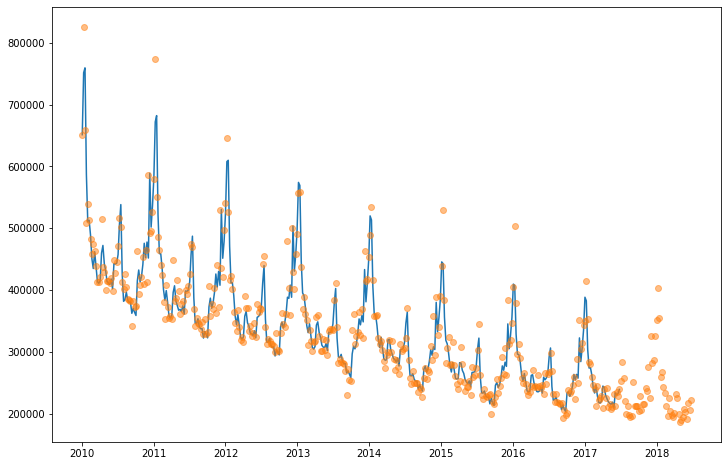

In [112]:
# just a quick check against in-sample yhat
fig, ax = plt.subplots(1,1, figsize=(12,8))
y = df[response_col]
plt.plot(train_df['week'], np.exp(yhat_in))
plt.plot(df['week'], df[response_col], 'o', alpha=0.5)

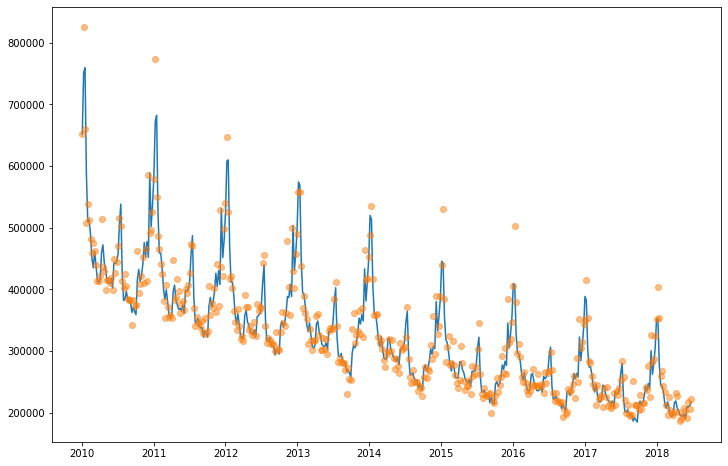

In [113]:
# a out-of-sample check for prediction
fig, ax = plt.subplots(1,1, figsize=(12,8))
y = df[response_col]
plt.plot(df['week'], np.exp(yhat))
plt.plot(df['week'], df[response_col], 'o', alpha=0.5)

In [48]:
mod.predict(df)

torch.Size([1, 392, 3])


NameError: name 'regressor_beta' is not defined

In [49]:
%debug

> /Users/edwinng/work/orbit-super/orbit/orbit/eswr.py(255)_predict()
    253             for idx in range(local_level_len, full_len):
    254                 local_trend[:, idx] = local_trend[:, idx-1]
--> 255                 regressor_coef[:, idx, :] = regressor_coef[:, idx-1, :]
    256                 # global_trend[:, idx] = global_trend_slope * idx * self.time_delta
    257                 global_trend[:, idx] = global_trend_slope * idx



ipdb>  regressor_coef.shape


torch.Size([1, 392, 3])


ipdb>  local_trend.shape


torch.Size([1, 443])


ipdb>  q


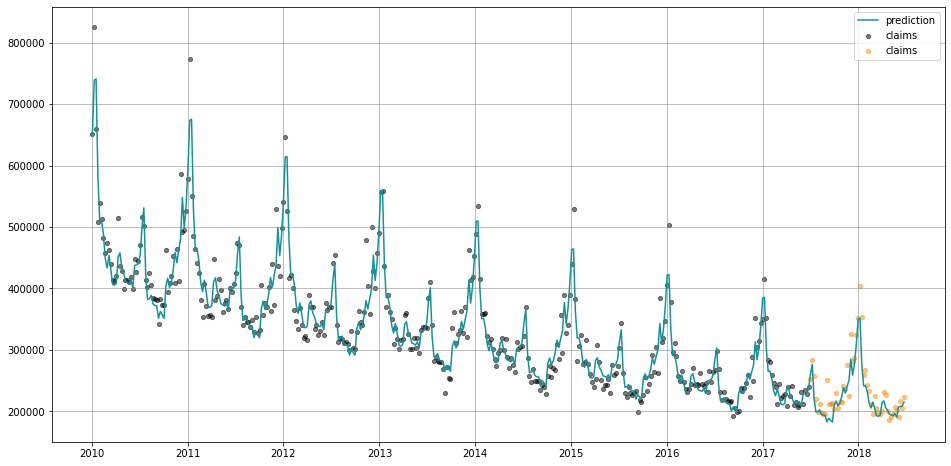

In [96]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=mod.date_col, actual_col=mod.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [97]:
# backtest on more data

# data = pd.read_csv('./data/uber_uscan_rider_uFT.csv', parse_dates=['event_week'])
# data = pd.read_csv('./data/uber_uscan_driver_uFT.csv', parse_dates=['event_week'])
# response_col = 'uFT'
# date_col='event_week'
# key_col = 'city_name'
# predicted_col='prediction'
# min_train_len = 380
# forecast_len = 26
# incremental_len = 13
# n_splits=2
# key_col = "city_name"
# window_type = 'expanding'
# seasonality=52

data = pd.read_csv('./data/m3_monthly.csv', parse_dates=['date'])
response_col = 'value'
date_col='date'
key_col = 'key'
predicted_col='prediction'
min_train_len = 380
forecast_len = 18
incremental_len = 18
n_splits=1
window_type = 'expanding'
seasonality=12

# data = pd.read_csv('./data/m4_weekly.csv', parse_dates=['date'])
# response_col = 'value'
# date_col='date'
# key_col = 'key'
# predicted_col='prediction'
# min_train_len = 380
# forecast_len = 13
# incremental_len = 13
# n_splits=1
# window_type = 'expanding'
# seasonality=52

In [98]:
seed=2020

In [99]:
data.dtypes

key              object
value           float64
date     datetime64[ns]
dtype: object

In [100]:
uni_keys = data[key_col].unique()

Instantiate a model that we want to backtest

In [106]:
mod = DLTRH(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    normalize_seasonality=1,
    infer_method='map', predict_method='map')

In [107]:
%%time
bt_result, bt_scores = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:46<00:00,  8.41it/s]


CPU times: user 2min 32s, sys: 4.98 s, total: 2min 37s
Wall time: 2min 47s


In [108]:
bt_scores['smape'].mean()

0.15820130184405004

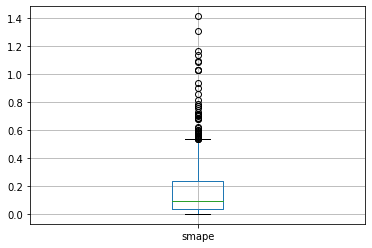

In [109]:
bt_scores.boxplot(column='smape')

In [45]:
mod2 = DLT(
    is_multiplicative=True, seed=seed,
    response_col=response_col, date_col=date_col, seasonality=seasonality, 
    infer_method='map', predict_method='map')

In [46]:
%%time
bt_result2, bt_scores2 = run_multi_series_backtest(
    data=data, 
    response_col=response_col, 
    key_col=key_col, 
    date_col=date_col,
    model=mod2,
    min_train_len=min_train_len, 
    incremental_len=incremental_len, 
    forecast_len=forecast_len, 
    predicted_col=predicted_col, 
    n_splits=n_splits,
    window_type = window_type
)

100%|██████████| 1399/1399 [02:02<00:00, 11.39it/s]


CPU times: user 1min 53s, sys: 5.8 s, total: 1min 59s
Wall time: 2min 4s


In [47]:
bt_scores2['smape'].mean()

0.14827365152127073

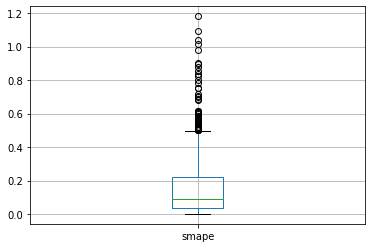

In [48]:
bt_scores2.boxplot(column='smape')

In [ ]:
# TODO:
# compare 
# 1. using normalize vs. not use -- non-normalized is better 
# 2. subtract init lev by s[1] vs. by s[SEASONALITY] -- after some thought, s[SEASONALITY]
# should be the right one
# 3. changing different ways to get init_lev prior -- using l[1] seems even worse
# 4. random initialize seasonality vs. random normal initialization -- not too much difference
# 5. changing NUs of student t to see if letting stan to optimize makes better accuracy <--- This is TODO!
# tried 10 vs. 5 doesn't matter (when normalizing)

# NOTES:
# it doesn't do as well as the original DLT but meanwhile does not do worse (improvment on rider but relatively similar in driver and slightly worse in M3 Monthly)